# Content
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Stef0916/chemoinformatics-bioinformatics/blob/main/solubility_prediction-2005/notebooks/regression-model-2.ipynb)

1. [Importe Libraries](#1)
2. [Load Data](#2)
3. [Split Train and Test Sets](#3)
4. [Models Comparision](#4)
5. [Linear Regression Model](#5)
    * 5.1 [Equation](#6)
    * 5.2 [Experimental vs Predicted](#7)
    * 5.3 [Residuals](#8)
    * 5.4 [Analysis of the Visualization](#9)
6. [Prediction with Linear Regression](#10)
    * 6.1 [Load Validation Dataset](#11)
    * 6.2 [Molecular Descriptors - Validation Dataset](#12)
    * 6.3 [Predictions](#13)
    * 6.4 [Analysis of Predictions](#14)
        - 6.5.1 [MSE and R^2](#15)
        - 6.5.2 [Scatter Plot](#16)
        - 6.5.3 [Residual Plot](#17)
        - 6.5.4 [Absolute Difference](#18)
7. [Random Forest](#19)
    * 7.1 [Hyperparameter](#20)
    * 7.2 [Predictions](#23)
    * 7.3 [Analysis of the Predictions](#24)
        - 7.3.1 [MSE and R^2](#25)
        - 7.3.2 [Scatter Plot](#26)
        - 7.3.3 [Residual Plot](#27)
        - 7.3.4 [Absolute Difference](#28)
8. [Analysis Linear Regression vs Random Forest](#29)
9. [Conclusion](#30)

## 1. Import Libraries<a name = 1></a>

In [2]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 47.1 MB/s eta 0:00:00


In [3]:
! pip install mols2grid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.9 MB/s eta 0:00:00


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Descriptors import MolWt, NumRotatableBonds
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem import PandasTools #Add the ability to add a molecule to a dataframe
import mols2grid #The mols2grid library provides a convenient way of displaying molecules in a grid

## 2. Load Data<a name = 2></a>

In [5]:
df = pd.read_csv('data_to_train_model.csv')

In [6]:
df

,MW,LogP,NumRotableBonds,aromatic_portion,LogS
0,167.850,2.59540,0,0.000000,-2.180
1,133.405,2.37650,0,0.000000,-2.000
2,167.850,2.59380,1,0.000000,-1.740
3,133.405,2.02890,1,0.000000,-1.480
4,187.375,2.91890,1,0.000000,-3.040
...,...,...,...,...,...
1077,287.343,1.98820,8,0.000000,1.144
1078,286.114,3.42130,2,0.333333,-4.925
1079,308.333,3.60960,4,0.695652,-3.893
1080,354.815,2.56214,3,0.521739,-3.790


## 3. Split Train and Test Sets<a name=3></a>

In [7]:
X = df.drop('LogS', axis=1)
y = df['LogS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train

,MW,LogP,NumRotableBonds,aromatic_portion
816,302.238,1.9880,1,0.727273
237,74.123,0.6347,1,0.000000
621,46.069,-0.0014,0,0.000000
630,150.177,1.8633,2,0.545455
275,102.177,1.5574,3,0.000000
...,...,...,...,...
330,226.276,1.1850,4,0.000000
466,235.308,2.6200,2,0.375000
121,395.327,7.9274,1,0.631579
1044,128.156,0.0586,0,0.750000


In [9]:
y_train

816    -3.083
237     0.100
621     1.100
630    -2.320
275    -0.800
        ...  
330    -2.658
466    -3.140
121    -8.940
1044   -2.273
860    -1.960
Name: LogS, Length: 865, dtype: float64

In [10]:
X_train.shape

(865, 4)

In [11]:
y_train.shape

(865,)

## 4. Model Comparision<a name = 4></a>

In [12]:
# Models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

# Train and evaluate models
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results.append([name, mse, r2])

# Convert results to DataFrame for easier visualization
results_df = pd.DataFrame(results, columns=['Model', 'MSE', 'R2'])

# Sort by MSE (you can also sort by R2 if you prefer)
results_df = results_df.sort_values(by='MSE')

# Display results
print(results_df)

               Model       MSE        R2
5  Gradient Boosting  0.533178  0.870976
4      Random Forest  0.533981  0.870782
3      Decision Tree  0.782529  0.810636
0  Linear Regression  0.944300  0.771489
1              Ridge  0.944380  0.771469
2              Lasso  1.300378  0.685322


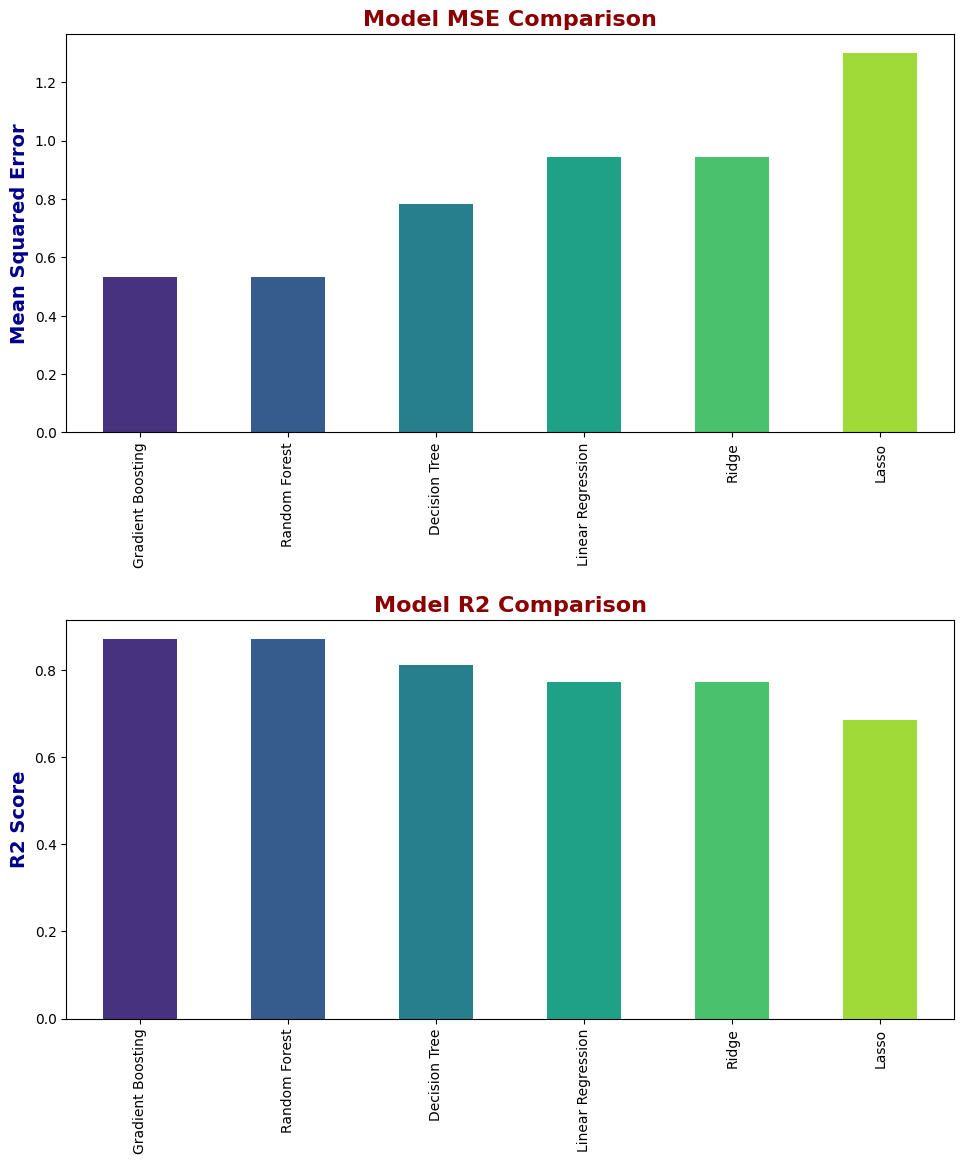

In [13]:
title_font = {"color" : "darkred", "weight" : "bold", "size" : 16}
axis_font = {"color" : "darkblue", "weight" : "bold", "size" : 14}

# Get color palette from seaborn
colors = sns.color_palette('viridis', n_colors=len(results_df['Model']))

# Visualize results: MSE and R2 in two separate plots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

results_df.plot(x='Model', y='MSE', kind='bar', legend=False, ax=ax[0], color=colors)
ax[0].set_ylabel('Mean Squared Error', fontdict=axis_font)
ax[0].set_xlabel('')  # Remove x-label for the first plot
ax[0].set_title('Model MSE Comparison', fontdict=title_font)

results_df.plot(x='Model', y='R2', kind='bar', legend=False, ax=ax[1], color=colors)
ax[1].set_xlabel('')
ax[1].set_ylabel('R2 Score', fontdict=axis_font)
ax[1].set_title('Model R2 Comparison', fontdict=title_font)

plt.tight_layout(pad=2.0)  # Adjust space between plots
plt.show()

The better model is the Random Forest, for which I will proceed to compute the hyperparameters. But first, I'll use the linear regression model to extract the coefficients and interception so I can compare the results with those of the publication.

## 5. Linear Regression Model<a name = 5></a>

### 5.1 Equation<a name =6 ></a>

In [14]:
# Extract the Linear Regression model
lr_model = models["Linear Regression"]

# Predict on test data
predictions = lr_model.predict(X_test)

# Compute MSE and R2
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Access the coefficients and intercept
coefficients = lr_model.coef_
intercept = lr_model.intercept_

# Display results
print(f"Linear Regression MSE: {mse}")
print(f"Linear Regression R2: {r2}")
print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

Linear Regression MSE: 0.9442996596238328
Linear Regression R2: 0.7714888747058147
Coefficients: [-0.00638247 -0.76584473  0.00369342 -0.33806355]
Intercept: 0.28396616034634947


In [15]:
feature_names = df.drop(columns=['LogS']).columns

# Map feature names to coefficients
coeff_mapping = dict(zip(feature_names, coefficients)) #The coefficients variable will contain the coefficients
                                                       #in the order of the features as they were input to the model.

# Display the mapping
for feature, coeff in coeff_mapping.items():
    print(f"{feature}: {coeff}")

MW: -0.006382471136127873
LogP: -0.7658447348620592
NumRotableBonds: 0.0036934224243206915
aromatic_portion: -0.3380635479459064


The equation after fitting the Linear Regression is:

$$ LogS = 0.28 - 0.77LogP - 0.0063MW + 0.0037RB - 0.33AP $$

For comparision with the original paper:

$$ LogS = 0.16 - 0.63 cLogP - 0.0062 MW + 0.066 RB - 0.74 AP $$

The reproduction by Pat Walters:

$$ LogS = 0.26 - 0.74 LogP - 0.0066 MW + 0.0034 RB - 0.42 AP $$


### 5.2 Experimental vs Predicted<a name = 7 ></a>

In [16]:
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

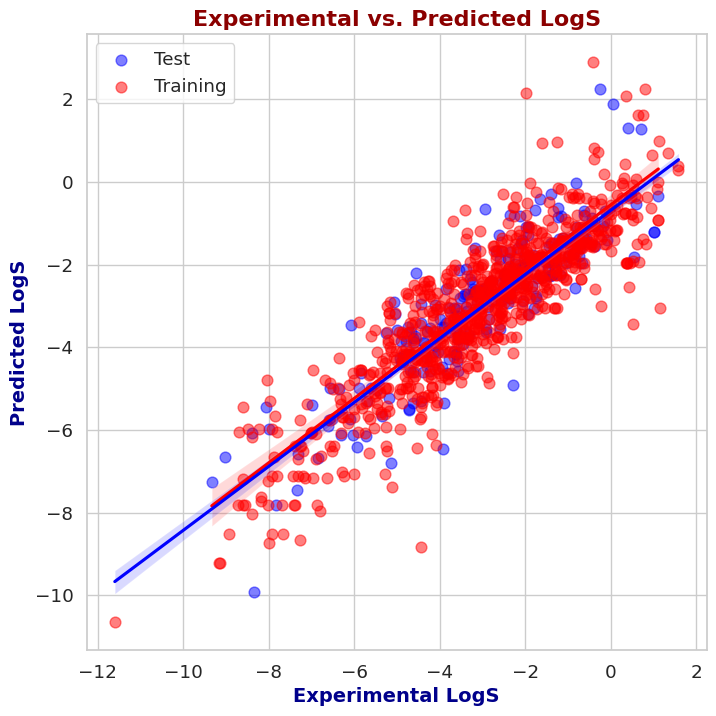

In [17]:
# Set style and context
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Create the regplot
plt.figure(figsize=(8, 8))
ax = sns.regplot(x=y_test, y=y_pred_test, scatter_kws={'alpha':0.5, 's':60}, color='blue', line_kws={'color':'red'}, label="Test")
ax = sns.regplot(x=y_train, y=y_pred_train, scatter_kws={'alpha':0.5, 's':60}, color='red', line_kws={'color':'blue'}, label="Training")

# Customize the plot details
ax.set_title('Experimental vs. Predicted LogS', fontdict=title_font)
ax.set_xlabel('Experimental LogS', fontdict=axis_font)
ax.set_ylabel('Predicted LogS', fontdict=axis_font)
plt.savefig("logS_exp_vs_pedicted_xtrain_xtest.pdf", bbox_inches='tight')

# Display the plot
plt.legend()
plt.show();

### 5.3 Residuals<a name =8 ></a>

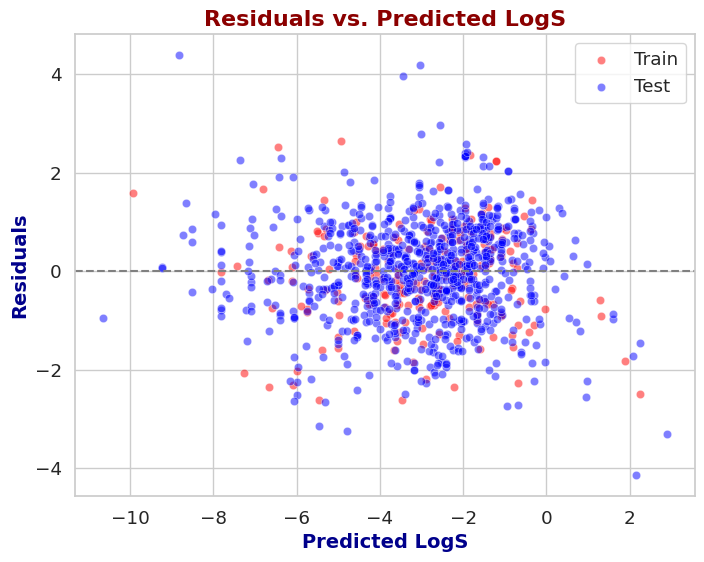

In [18]:
# Calculate the residuals
residuals_test = y_test - y_pred_test
residuals_train = y_train - y_pred_train

# Set style and context for a more appealing plot
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Create the residuals plot
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=y_pred_test, y=residuals_test, alpha=0.5, color='red', label='Train')
ax = sns.scatterplot(x=y_pred_train, y=residuals_train, alpha=0.5, color='blue', label='Test')

# Plot a horizontal line at y=0 for reference
plt.axhline(0, color='grey', linestyle='--')

# Customize the plot details
ax.set_title('Residuals vs. Predicted LogS', fontdict=title_font)
ax.set_xlabel('Predicted LogS', fontdict=axis_font)
ax.set_ylabel('Residuals', fontdict=axis_font)
# ax.set_xlim(1.8, 14.5)
# ax.set_ylim(-6, 6)

plt.savefig("residuals_xtest_xtrain.pdf", bbox_inches='tight')
plt.legend()
plt.show()

### 5.4 Analysis of the Visualization<a name = 9></a>

From the plots, we can see that the model performs reasonably well on the training and test data, with the predictions clustering closely around the ideal line. The residuals plot scatter fairly randomly around the zero line.

## 6. Prediction with Linear Regression<a name = 10></a>

### 6.1 Load Validation Dataset<a name = 11></a>

In [23]:
validation_data = pd.read_csv('solubility_validation_molecules.csv')

In [24]:
validation_list = [Chem.MolFromSmiles(element) for element in validation_data.SMILES]

In [25]:
validation_list[:5]

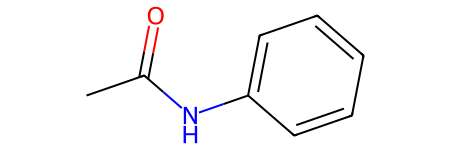

In [26]:
Chem.MolFromSmiles(validation_data['SMILES'].iloc[0])

### 6.2 Molecular Descriptors to Validation Dataset<a name = 12></a>

**MW, LogP and RB descriptors**

In [27]:
# Creat a DataFrame from the mol_list
df_mol_list = pd.DataFrame(validation_list, columns=['Molecule'])

In [28]:
df_mol_list.head()

,Molecule
0,<rdkit.Chem.rdchem.Mol object at 0x7e16f9062a40>
1,<rdkit.Chem.rdchem.Mol object at 0x7e16f9062ff0>
2,<rdkit.Chem.rdchem.Mol object at 0x7e16f90631b0>
3,<rdkit.Chem.rdchem.Mol object at 0x7e16f9063bc0>
4,<rdkit.Chem.rdchem.Mol object at 0x7e16f90630d0>


In [29]:
# Add MW, LogP and NumRotatableBonds
df_mol_list['MW'] = [MolWt(x) for x in df_mol_list.Molecule]
df_mol_list['LogP'] = [MolLogP(x) for x in df_mol_list.Molecule]
df_mol_list['NumRotableBonds'] = [NumRotatableBonds(x) for x in df_mol_list.Molecule]

In [30]:
df_mol_list.head()

,Molecule,MW,LogP,NumRotableBonds
0,<rdkit.Chem.rdchem.Mol object at 0x7e16f9062a40>,135.166,1.6450,1
1,<rdkit.Chem.rdchem.Mol object at 0x7e16f9062ff0>,267.245,-1.9800,2
2,<rdkit.Chem.rdchem.Mol object at 0x7e16f90631b0>,136.114,0.0585,0
3,<rdkit.Chem.rdchem.Mol object at 0x7e16f9063bc0>,290.323,1.2576,5
4,<rdkit.Chem.rdchem.Mol object at 0x7e16f90630d0>,222.251,-0.8561,2


In [31]:
df_mol_list.shape

(100, 4)

In [32]:
# Visualize the DataFrame of the molecules within a grid
two_decimals = lambda x: f"{x:.2f}"
mols2grid.display(df_mol_list,mol_col="Molecule",subset=["img","MW","LogP","NumRotableBonds"],transform={"MW" : two_decimals, "LogP": two_decimals})

MolGridWidget()

In [33]:
df_mol_list.drop(['Molecule'], axis=1, inplace=True)

In [34]:
df_mol_list.head()

,MW,LogP,NumRotableBonds
0,135.166,1.6450,1
1,267.245,-1.9800,2
2,136.114,0.0585,0
3,290.323,1.2576,5
4,222.251,-0.8561,2


In [35]:
df_mol_list.shape

(100, 3)

**Aromatic Portion**

In [36]:
def aromatic_portion(smiles):
    mol = Chem.MolFromSmiles(smiles)
    num_aromatic_atoms = sum([atom.GetIsAromatic() for atom in mol.GetAtoms()])
    total_atoms = mol.GetNumAtoms()
    return num_aromatic_atoms / total_atoms if total_atoms > 0 else 0

In [37]:
validation_clean = validation_data.copy()
validation_clean['aromatic_portion'] = validation_clean['SMILES'].apply(aromatic_portion)

In [38]:
validation_clean

,Chemical name,SMILES,LogS exp (mol/L),aromatic_portion
0,Acetanilide,O=C(Nc1ccccc1)C,-1.40,0.600000
1,Adenosine,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,-1.73,0.473684
2,Allopurinol,c1c2c([nH]n1)ncnc2O,-2.26,0.900000
3,Trimethoprim,COc1cc(cc(c1OC)OC)Cc2cnc(nc2N)N,-2.95,0.571429
4,Acetazolamide,O=S(=O)(c1nnc(s1)NC(=O)C)N,-2.44,0.384615
...,...,...,...,...
95,Sulfanilamide,O=S(=O)(c1ccc(N)cc1)N,-1.36,0.545455
96,Gliclazide,O=S(=O)(c1ccc(cc1)C)NC(=O)NN3CC2CCCC2C3,-4.29,0.272727
97,Trihexyphenidyl,OC(c1ccccc1)(CCN2CCCCC2)C3CCCCC3,-5.20,0.272727
98,Triphenylene,c1ccc2c(c1)c3ccccc3c4c2cccc4,-6.73,1.000000


In [39]:
validation_logs = validation_clean[['Chemical name', 'LogS exp (mol/L)']]

In [40]:
validation_logs

,Chemical name,LogS exp (mol/L)
0,Acetanilide,-1.40
1,Adenosine,-1.73
2,Allopurinol,-2.26
3,Trimethoprim,-2.95
4,Acetazolamide,-2.44
...,...,...
95,Sulfanilamide,-1.36
96,Gliclazide,-4.29
97,Trihexyphenidyl,-5.20
98,Triphenylene,-6.73


In [41]:
validation_clean.drop(['SMILES', 'LogS exp (mol/L)'], axis=1, inplace=True)

In [42]:
validation_clean

,Chemical name,aromatic_portion
0,Acetanilide,0.600000
1,Adenosine,0.473684
2,Allopurinol,0.900000
3,Trimethoprim,0.571429
4,Acetazolamide,0.384615
...,...,...
95,Sulfanilamide,0.545455
96,Gliclazide,0.272727
97,Trihexyphenidyl,0.272727
98,Triphenylene,1.000000


In [43]:
validation_logs.rename(columns={'LogS exp (mol/L)': 'LogS'}, inplace=True)

In [44]:
validation_logs.to_csv('validation_logs.csv', index=False)

In [45]:
validation_df = pd.concat([validation_clean, df_mol_list], axis=1)

In [46]:
validation_df

,Chemical name,aromatic_portion,MW,LogP,NumRotableBonds
0,Acetanilide,0.600000,135.166,1.64500,1
1,Adenosine,0.473684,267.245,-1.98000,2
2,Allopurinol,0.900000,136.114,0.05850,0
3,Trimethoprim,0.571429,290.323,1.25760,5
4,Acetazolamide,0.384615,222.251,-0.85610,2
...,...,...,...,...,...
95,Sulfanilamide,0.545455,172.209,-0.08380,1
96,Gliclazide,0.272727,323.418,1.62982,3
97,Trihexyphenidyl,0.272727,301.474,4.33050,5
98,Triphenylene,1.000000,228.294,5.14620,0


In [47]:
validation_df.to_csv('solubility_validaton_molecular_descriptors.csv', index=False)

### 6.3 Prediction<a name = 13></a>

In [48]:
features = ['LogP', 'MW', 'NumRotableBonds', 'aromatic_portion']
X_test_new = validation_df[features]

**I need to re-order the features so they match the dataset I used to train the model.**

In [49]:
# Correct the column name in the ordered_features list
ordered_features = ['MW', 'LogP', 'NumRotableBonds', 'aromatic_portion']

In [50]:
# Re-order the features in the test dataset
X_validation_ordered = validation_df[ordered_features]

In [51]:
X_validation_ordered

,MW,LogP,NumRotableBonds,aromatic_portion
0,135.166,1.64500,1,0.600000
1,267.245,-1.98000,2,0.473684
2,136.114,0.05850,0,0.900000
3,290.323,1.25760,5,0.571429
4,222.251,-0.85610,2,0.384615
...,...,...,...,...
95,172.209,-0.08380,1,0.545455
96,323.418,1.62982,3,0.272727
97,301.474,4.33050,5,0.272727
98,228.294,5.14620,0,1.000000


In [52]:
X

,MW,LogP,NumRotableBonds,aromatic_portion
0,167.850,2.59540,0,0.000000
1,133.405,2.37650,0,0.000000
2,167.850,2.59380,1,0.000000
3,133.405,2.02890,1,0.000000
4,187.375,2.91890,1,0.000000
...,...,...,...,...
1077,287.343,1.98820,8,0.000000
1078,286.114,3.42130,2,0.333333
1079,308.333,3.60960,4,0.695652
1080,354.815,2.56214,3,0.521739


In [53]:
validation_predictions = lr_model.predict(X_validation_ordered)

In [54]:
validation_predictions

array([-2.03768623, -0.05809328, -0.93383663, -2.7068504 , -0.60154235,
       -1.77770443, -2.348191  , -4.34292529, -1.31245333, -2.37370246,
       -1.83939552, -1.2827619 , -1.86511027, -3.70905216, -5.88736   ,
       -3.16369461, -3.69894897, -5.83279694, -0.18250877, -2.90914882,
       -3.53308657, -4.1478828 , -5.48165344, -1.93905143, -4.30826488,
       -1.34033019, -4.87886449, -4.39257202, -1.46296458, -1.89589486,
       -3.50668767, -3.5010538 , -3.01828076, -1.77382166, -3.38413619,
       -0.36628197, -1.38071656, -1.14837453, -4.01800744, -3.23860406,
       -1.00868465, -5.03254791, -2.47957899, -2.89292554, -4.42183431,
       -1.75644721, -6.05830139, -1.84661991, -1.76742131, -2.8875248 ,
       -2.90723233, -5.33689734, -2.56999988, -4.85562273, -0.39839296,
       -1.63181532, -4.25623855, -5.14718495, -2.58643124, -2.82566906,
       -1.29263335, -2.19933082, -2.25069898, -3.89238512, -1.53450316,
       -0.26509337, -3.64100829,  0.03246342,  0.31084933, -3.12

### 6.4 Analysis of the Prediction<a name = 14></a>

#### 6.4.1 MSE and R^2<a name = 15></a>

In [55]:
# Extract actual experimental results
actual_values = validation_logs["LogS"]

# Calculate metrics
mse = mean_squared_error(actual_values, validation_predictions)
r2 = r2_score(actual_values, validation_predictions)

mse, r2

(1.407871410931318, 0.5156277537662151)

#### 6.4.2 Scatter Plot<a name = 16></a>

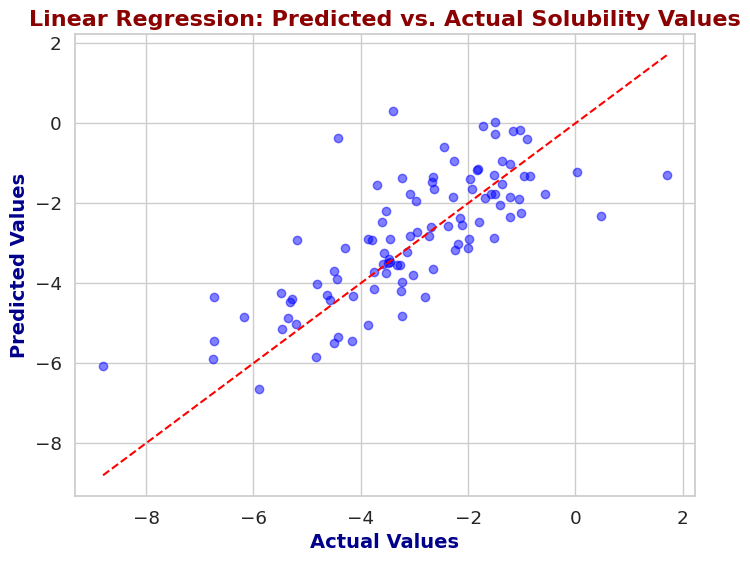

In [56]:
# Scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, validation_predictions, alpha=0.5, color='blue')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--')
plt.title('Linear Regression: Predicted vs. Actual Solubility Values', fontdict=title_font)
plt.xlabel('Actual Values', fontdict=axis_font)
plt.ylabel('Predicted Values', fontdict=axis_font)
plt.grid(True)
plt.savefig("LR_predicted_vs_actual.pdf", bbox_inches='tight')
plt.show()

#### 6.4.3 Residual Plot<a name = 17></a>

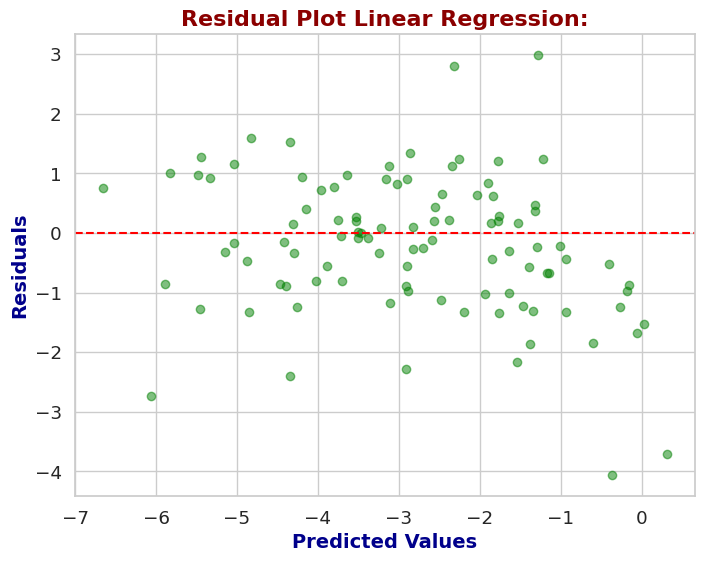

In [57]:
# Residual plot
residuals = actual_values - validation_predictions
plt.figure(figsize=(8, 6))
plt.scatter(validation_predictions, residuals, alpha=0.5, color='green')
plt.title('Residual Plot Linear Regression:', fontdict=title_font)
plt.xlabel('Predicted Values', fontdict=axis_font)
plt.ylabel('Residuals', fontdict=axis_font)
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True)
plt.savefig("LR_residuals.pdf", bbox_inches='tight')
plt.show()

#### 6.4.4 Absolute Difference<a name = 18></a>

In [58]:
# Create a DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    'Actual Values': actual_values,
    'Predicted Values': validation_predictions,
    'Absolute Difference': abs(actual_values - validation_predictions)
})

# Display the first few rows of the DataFrame
print(comparison_df.head())

   Actual Values  Predicted Values  Absolute Difference
0          -1.40         -2.037686             0.637686
1          -1.73         -0.058093             1.671907
2          -2.26         -0.933837             1.326163
3          -2.95         -2.706850             0.243150
4          -2.44         -0.601542             1.838458


In [59]:
comparison_df.to_csv('validation_prediction_linear_model.csv', index=False)

In [60]:
# Compute summary statistics on the "Difference" column
difference_statistics = comparison_df["Absolute Difference"].describe()

difference_statistics

count    100.000000
mean       0.909524
std        0.765835
min        0.004679
25%        0.309157
50%        0.832088
75%        1.234048
max        4.063718
Name: Absolute Difference, dtype: float64

- Count: There are 100 data points.
- Mean: The average difference between actual and predicted values is approximately 0.91.
- Standard Deviation: The standard deviation is approximately 0.77, indicating the spread of the differences.
- Min: The smallest difference is approximately 0.005, which means there are some predictions very close to the actual values.
- 25th Percentile: 25% of the predictions have a difference of about 0.31 or less.
- Median (50th Percentile): The median difference is approximately 0.83.
- 75th Percentile: 75% of the predictions have a difference of about 1.23 or less.
- Max: The largest difference is approximately 4.06.

**Conclusions:**


---



1. The model, on average, has an error of about 0.91 in its predictions.
2. The distribution of differences is somewhat varied, with a standard deviation of about 0.77.
3. While there are predictions that are very close to the actual values (min difference of 0.005), there are also instances where the model has a significant error (max difference of 4.06).

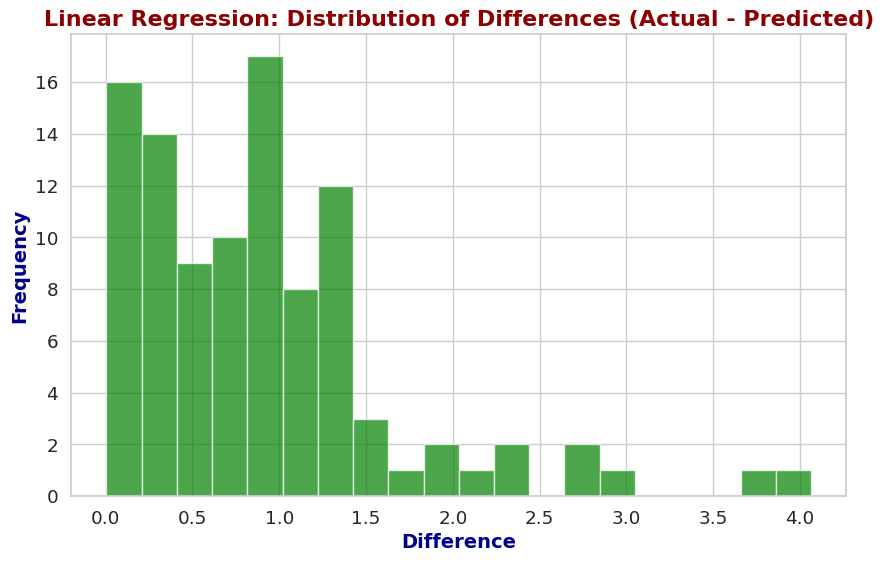

In [61]:
# Histogram of differences
plt.figure(figsize=(10, 6))
plt.hist(comparison_df["Absolute Difference"], bins=20, color='green', alpha=0.7)
plt.title('Linear Regression: Distribution of Differences (Actual - Predicted)', fontdict=title_font)
plt.xlabel('Difference', fontdict=axis_font)
plt.ylabel('Frequency', fontdict=axis_font)
plt.grid(True)
plt.savefig("LR_difference.pdf", bbox_inches='tight')

plt.show()

**Distribution of Differences:**


---

The histogram shows the distribution of the differences between the actual and predicted values.
2. Most of the differences are in the range of 0 to 1.5, with the highest frequency between 0.5 and 1.
3. There are a few predictions with larger differences (e.g., between 3 and 4.5), but they are less frequent.

## 7. Random Forest<a name = 19></a>

### 7.1 Hyperparameters<a name = 20></a>

In [62]:
from sklearn.model_selection import RandomizedSearchCV

#### 7.1.1 Defining the Hyperparameters grid<a id = 21></a>

In [63]:
param_dist = {
    'n_estimators': np.arange(10, 200, 10),
    'max_features': ['sqrt', 'log2'],
    'max_depth': np.arange(1, 20),
    'min_samples_split': np.arange(2, 20),
    'min_samples_leaf': np.arange(1, 20),
    'bootstrap': [True, False]
}

#### 7.1.2 Initializing the GridSearchCV<a id = 22></a>

In [64]:
rf = RandomForestRegressor(random_state = 5)
rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, verbose=1, n_jobs=-1)

In [65]:
rf_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=5),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
                   verbose=1)

In [66]:
rf_best_params = rf_random_search.best_params_
print(rf_best_params)

{'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 19, 'bootstrap': True}


In [67]:
random_forest_hyper = RandomForestRegressor(random_state=5, **rf_best_params)

In [68]:
# Fitting the model
random_forest_hyper.fit(X_train, y_train)

RandomForestRegressor(max_depth=19, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=70, random_state=5)

In [69]:
# Evaluating the models on the test data
rf_test_preds_hyper = random_forest_hyper.predict(X_test)

# Calculating performance metrics for the test set
mse_test_hyper = mean_squared_error(y_test, rf_test_preds_hyper, squared=True)
r2_test_hyper = r2_score(y_test, rf_test_preds_hyper)
print(mse_test_hyper, r2_test_hyper)

0.5013955197014658 0.8786672712874998


In [70]:
rf_mse = results_df.loc[results_df['Model'] == 'Random Forest', 'MSE'].values[0]
rf_r2 = results_df.loc[results_df['Model'] == 'Random Forest', 'R2'].values[0]

results_rf_hyper = {
    'Model': ['Random Forest', 'Random Forest Hyperparameters'],
    'MSE': [rf_mse, mse_test_hyper],
    'R^2': [rf_r2, r2_test_hyper]
}

# Creating a DataFrame from the results
results_rf2 = pd.DataFrame(results_rf_hyper)

results_rf2

,Model,MSE,R^2
0,Random Forest,0.533981,0.870782
1,Random Forest Hyperparameters,0.501396,0.878667


### 7.2 Predictions<a name = 23></a>

In [71]:
validation_predictions_rf = random_forest_hyper.predict(X_validation_ordered)

In [72]:
validation_predictions_rf

array([-1.85766134, -1.41891334, -1.84722969, -3.20523273, -2.15397783,
       -1.26200717, -2.50571308, -3.97327914, -0.69928221, -2.34891034,
       -2.1714881 , -1.5530109 , -2.20656205, -3.4169811 , -6.26004048,
       -3.35565849, -3.39796504, -6.16792341, -0.50367327, -2.89864603,
       -3.26948953, -4.37129876, -5.23917681, -2.51616359, -3.99552325,
       -2.17853766, -4.64475652, -4.72903599, -2.56199965, -1.87340233,
       -3.25118307, -3.47879085, -2.89903014, -2.58100533, -3.06867657,
       -2.13466834, -2.62623002, -2.44644151, -4.1393925 , -3.16694947,
       -2.22612389, -4.62022487, -2.29970927, -2.33684694, -4.38406135,
       -2.25021611, -8.16804928, -2.48520357, -2.00546622, -2.66492578,
       -3.09012791, -4.78984077, -2.45267299, -6.45986729, -1.0980137 ,
       -1.30043117, -3.78028645, -5.11970485, -2.56812286, -2.887687  ,
       -2.49424875, -2.2114078 , -2.36515607, -3.97350605, -2.35580644,
       -1.54715006, -3.55331187, -0.60839803, -1.91199293, -3.26

### 7.3 Analysis of the Prediction<a name = 24></a>

#### 7.3.1 MSE and R^2<a name = 25></a>

In [73]:
# Extract actual experimental results
actual_values_rf = validation_logs["LogS"]

# Calculate metrics
mse_rf = mean_squared_error(actual_values_rf, validation_predictions_rf)
r2_rf = r2_score(actual_values_rf, validation_predictions_rf)

mse_rf, r2_rf

(0.9152608807988759, 0.6851083378209948)

#### 7.3.2 Scatter Plot<a name = 26></a>

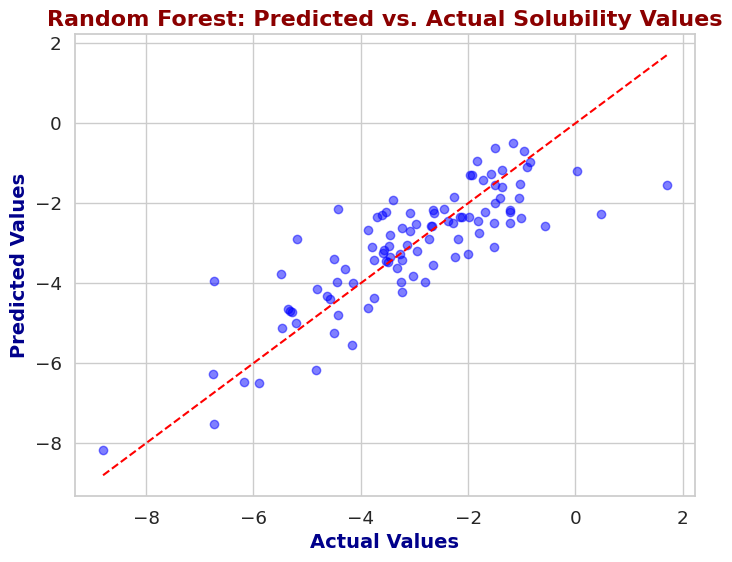

In [74]:
# Scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values_rf, validation_predictions_rf, alpha=0.5, color='blue')
plt.plot([min(actual_values_rf), max(actual_values_rf)], [min(actual_values_rf), max(actual_values_rf)], color='red', linestyle='--')
plt.title('Random Forest: Predicted vs. Actual Solubility Values', fontdict=title_font)
plt.xlabel('Actual Values', fontdict=axis_font)
plt.ylabel('Predicted Values', fontdict=axis_font)
plt.grid(True)
plt.savefig("RF_predicted_vs_actual.pdf", bbox_inches='tight')
plt.show()

#### 7.3.3 Residual Plot<a name = 27></a>

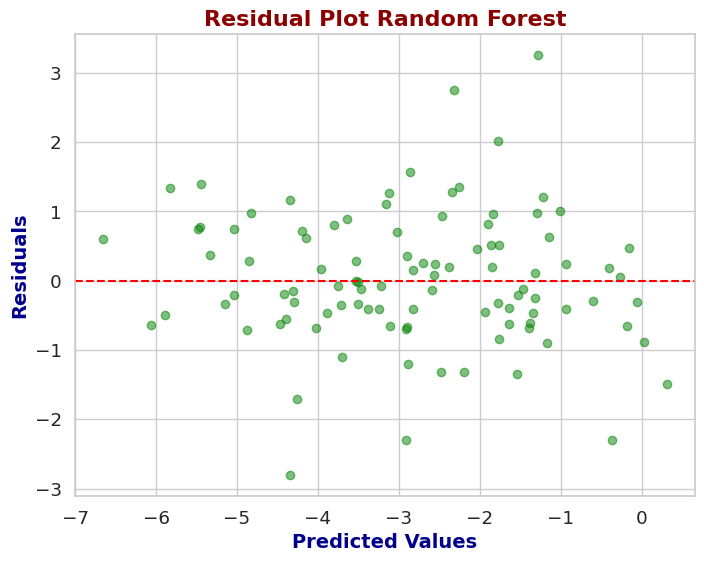

In [75]:
# Residual plot
residuals = actual_values_rf - validation_predictions_rf
plt.figure(figsize=(8, 6))
plt.scatter(validation_predictions, residuals, alpha=0.5, color='green')
plt.title('Residual Plot Random Forest', fontdict=title_font)
plt.xlabel('Predicted Values', fontdict=axis_font)
plt.ylabel('Residuals', fontdict=axis_font)
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True)
plt.savefig("RF_residuals.pdf", bbox_inches='tight')
plt.show()

#### 7.3.4 Absolute Difference<a name = 28></a>

In [76]:
# Create a DataFrame with actual and predicted values
comparison_df_rf = pd.DataFrame({
    'Actual Values': actual_values_rf,
    'Predicted Values': validation_predictions,
    'Absolute Difference': abs(actual_values_rf - validation_predictions_rf)
})

# Display the first few rows of the DataFrame
print(comparison_df_rf.head())

   Actual Values  Predicted Values  Absolute Difference
0          -1.40         -2.037686             0.457661
1          -1.73         -0.058093             0.311087
2          -2.26         -0.933837             0.412770
3          -2.95         -2.706850             0.255233
4          -2.44         -0.601542             0.286022


In [77]:
comparison_df_rf.to_csv('validation_prediction_random_forest_model.csv', index=False)

In [78]:
# Compute summary statistics on the "Difference" column
difference_statistics = comparison_df_rf["Absolute Difference"].describe()

difference_statistics

count    100.000000
mean       0.727440
std        0.624494
min        0.000510
25%        0.284483
50%        0.616820
75%        0.964678
max        3.253011
Name: Absolute Difference, dtype: float64

- Count: There are 100 data points.
- Mean: The average difference between actual and predicted values is approximately 0.71.
- Standard Deviation: The standard deviation is approximately 0.62, indicating the spread of the differences.
- Min: The smallest difference is approximately 0.0005, which means there are some predictions very close to the actual values.
- 25th Percentile: 29% of the predictions have a difference of about 0.29 or less.
- Median (50th Percentile): The median difference is approximately 0.62.
- 75th Percentile: 75% of the predictions have a difference of about 0.96 or less.
- Max: The largest difference is approximately 3.25.

**Conclusions:**


---



1. The model, on average, has an error of about 0.71 in its predictions.
2. The distribution of differences is somewhat varied, with a standard deviation of about 0.62.
3. While there are predictions that are very close to the actual values (min difference of 0.0005), there are also instances where the model has a significant error (max difference of 3.25).
**This shows an improvement wrt the Linear Regression Modell**

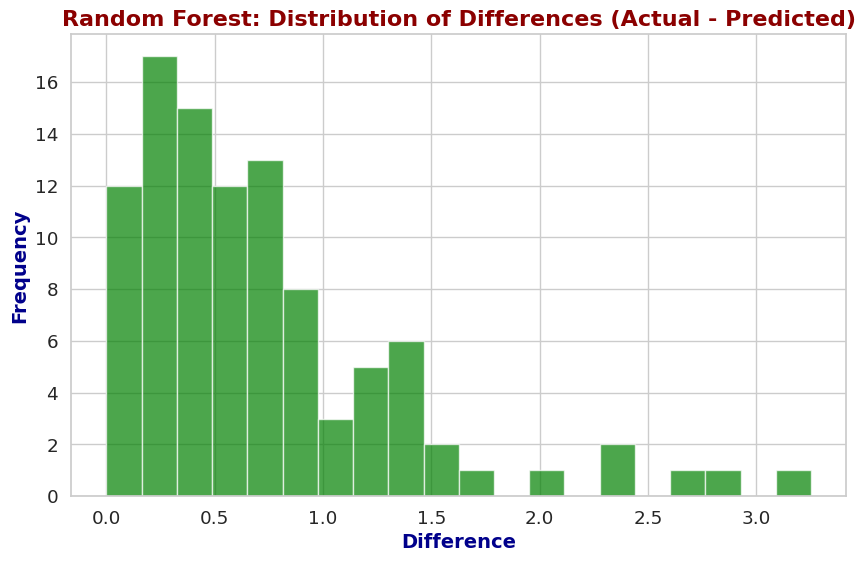

In [79]:
# Histogram of differences
plt.figure(figsize=(10, 6))
plt.hist(comparison_df_rf["Absolute Difference"], bins=20, color='green', alpha=0.7)
plt.title('Random Forest: Distribution of Differences (Actual - Predicted)', fontdict=title_font)
plt.xlabel('Difference', fontdict=axis_font)
plt.ylabel('Frequency', fontdict=axis_font)
plt.grid(True)
plt.savefig("RF_difference.pdf", bbox_inches='tight')

plt.show()

## 8. Analysis Linear Regression vs Random Forest<a name = 29></a>

In [80]:
# Create a DataFrame with actual and predicted values
comparison_lr_rf = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MSE': [mse, mse_rf],
    'R^2': [r2, r2_rf]
})

# Display the first few rows of the DataFrame
print(comparison_lr_rf)

               Model       MSE       R^2
0  Linear Regression  1.407871  0.515628
1      Random Forest  0.915261  0.685108


The **Random Forest** model outperforms the **Linear Regression** model in predicting solubility, both in terms of predictive accuracy (lower MSE) and goodness of fit (higher R^2).

## 9. Conclusion<a name = 30></a>

Gathering inspiration from previous study about prediction of solubility, this project aim and succeded to reproduce the results. Molecular descriptors like MW, LogP, RB and AP were extracted using the RDKit library, and subsequently utilized to construct different regression models. Linear regression and Random Forest were compared resulting in an outperformance of the last one, giving better predictions of the water solubility on the validation set. The results were comparable with the previous observation and improved by the use of Random Forest Model.